# Model Data Preparation - First Part (Irrigation and Remote Sensing Data)

We are going to take a deeper dive to look closely at the data we're going to use in the model, while we run through the data processing steps needed to prepare for the model run:

1. Write each field's soil and irrigation infomation into a study-wide properties file.
2. Process the Landsat data and run a simple analysis of per-field NDVI dynamics that will provide some information on likely subseasonal irrigation application dates, harvest, and fallowing.
3. Join our Earth Engine extracts and meteorology data into a per-field time series.
4. Finally, write a single model input file that has all of the data needed.

Step 3 depends on a successful run of Step 2, and Step 4 depends on Step 3, so ensure the code runs to completion on each before moving on.

Note: For this tutorial we're specifying the data directories to which the data is being written as needed. This gets messy but is worth it to learn about the workflow in our first project. In the subsequent tutorial, we will standardize the directory structure for the calibration project and use a configuration file to specify all directories, model metadata, date range for the study period, etc. This will simplify our lives by hiding a lot of what we do in that tutorial under the hood of our SWIM car, so we can focus on calibration.

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
import geopandas as gpd

# append the project path to the environment
home = os.path.expanduser('~')
root = os.path.join(home, 'PycharmProjects', 'swim-rs')
sys.path.append(root)

## 1. Write the soils and irrigation properties to a study-wide file.

We specify the inputs we've already built and the ouput `json` file.

In [2]:
# Step-specific imports
from prep.field_properties import write_field_properties
from prep.field_timeseries import join_daily_timeseries

In [3]:
# input properties files
irr = os.path.join(root, 'tutorials', '1_Boulder', 'data', 'properties', 'tutorial_irr.csv')
ssurgo = os.path.join(root, 'tutorials', '1_Boulder', 'data', 'properties', 'tutorial_ssurgo.csv')

# joined properties file
properties_json = os.path.join(root, 'tutorials', '1_Boulder', 'data', 'tutorial_properties.json')

# the original study area shapefile
shapefile_path = os.path.join(root, 'tutorials', '1_Boulder', 'data', 'gis', 'mt_sid_boulder.shp')

In [4]:
write_field_properties(shp=shapefile_path, irr=irr, ssurgo=ssurgo, js=properties_json, index_col='FID_1', shp_add=None,
                       targets=None)

We can check out the `properties_json` file to see what it's extracted. Let's check out the two objects that together create the southernmost center pivot circle in the study area, fields '043_000130' and '043_000128', which we will refer to below as field 130 and 128:

In [5]:
with open(properties_json, 'r') as f:
    properties_dict = json.load(f)
properties_dict['043_000130']

{'irr': {'1987': 0.0030635131931654,
  '1988': 0.0025164572658144,
  '1989': 0.0023705756851875,
  '1990': 0.0,
  '1991': 0.0,
  '1992': 0.0,
  '1993': 0.0014588158062692,
  '1994': 0.0094275971480151,
  '1995': 0.024982220682361,
  '1996': 0.0200587173362023,
  '1997': 0.0479768048286803,
  '1998': 0.0479768048286803,
  '1999': 0.0484509199657178,
  '2000': 0.0171593209212421,
  '2001': 0.0289392585568664,
  '2002': 0.0077499589708054,
  '2003': 0.020241069311986,
  '2004': 0.0281916154561534,
  '2005': 0.0322945349112857,
  '2006': 0.0333704115684093,
  '2007': 0.0220645890698225,
  '2008': 0.0371268622695526,
  '2009': 0.9096628311967764,
  '2010': 0.9652984190083702,
  '2011': 0.9652984190083702,
  '2012': 0.9476649829500904,
  '2013': 0.9652984190083702,
  '2014': 0.9652437134156348,
  '2015': 0.9686536953627894,
  '2016': 0.9652984190083702,
  '2017': 0.9652984190083702,
  '2018': 0.9682525210160654,
  '2019': 0.9716077973704846,
  '2020': 0.947938510913766,
  '2021': 0.930049782

In [6]:
properties_dict['043_000128']

{'irr': {'1987': 0.8699614938090657,
  '1988': 0.7338555045992043,
  '1989': 0.5718668410739706,
  '1990': 0.3133500386112555,
  '1991': 0.4701695217982862,
  '1992': 0.5569056361926673,
  '1993': 0.7949138207282026,
  '1994': 0.9451037250668474,
  '1995': 0.9798591083163916,
  '1996': 0.973439658750046,
  '1997': 0.9873081913647372,
  '1998': 0.9830845927957176,
  '1999': 0.9906439937171344,
  '2000': 0.9417311500900928,
  '2001': 0.9477881266449184,
  '2002': 0.9514496293844787,
  '2003': 0.9697886624745876,
  '2004': 0.9646457482966394,
  '2005': 0.9663110228568128,
  '2006': 0.9784459888946676,
  '2007': 0.9675717985490572,
  '2008': 0.9798958809407488,
  '2009': 0.9999317079833367,
  '2010': 0.9999317079833367,
  '2011': 0.9998056304141122,
  '2012': 0.9860789350647986,
  '2013': 0.9965433733104292,
  '2014': 0.9999106950551327,
  '2015': 0.9999317079833367,
  '2016': 0.9999317079833367,
  '2017': 0.9999317079833367,
  '2018': 0.9999317079833367,
  '2019': 0.9999317079833367,
  '2

This shows the fraction of the field that was irrigated each year since 1987, the soil hydraulic parameters AWC and Ksat, the soil texture information for clay and sand (loam = 100 - clay - sand), and the area of the field in square meters. 

We can see that field 130 was essentially unirrigated until 2009, while 128 seems to have gotten significant irrigation during the whole Landsat record, and was fully irrigated since 1994. Check out this area of interest by plotting it during 2007. We can readily see which field is which:

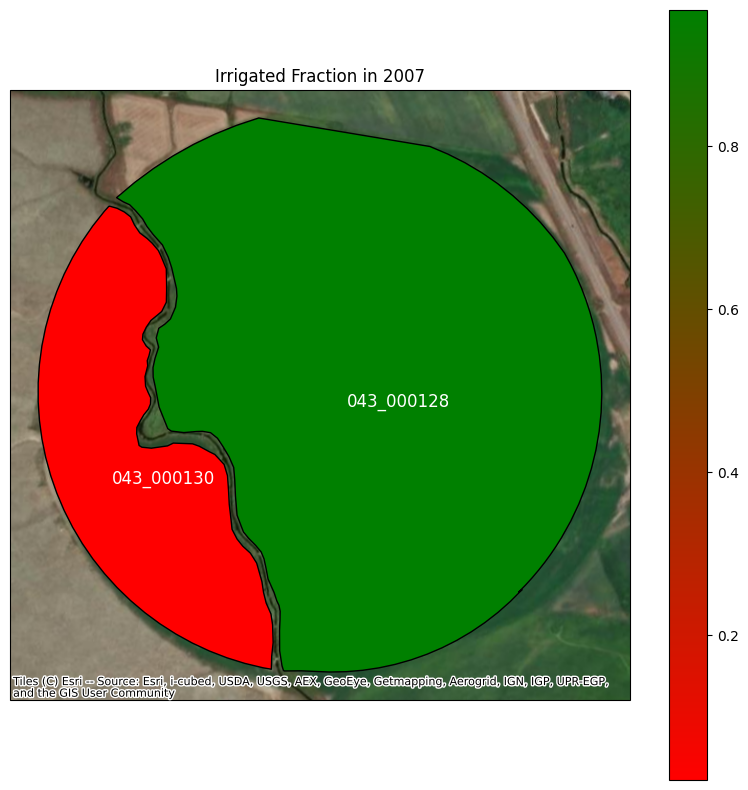

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import contextily as ctx
import cartopy.crs as ccrs
import random

# The following code raises a UserWarning that doesn't affect us, so we suppress it
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.") 

gdf = gpd.read_file(shapefile_path)
gdf.index = gdf['FID_1']

gdf['irr_2007'] = [properties_dict[i]['irr']['2007'] for i in gdf.index]
gdf = gdf.loc[[i for i in gdf.index if i in ['043_000130', '043_000128']]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})

cmap = mcolors.LinearSegmentedColormap.from_list("rg", ["r", "g"])

gdf.plot(ax=ax, 
        edgecolor='black', 
        column='irr_2007',
        cmap=cmap,
        legend=True,
        transform=ccrs.epsg(5071))

# Annotate the polygons with their index values
for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf.index):
    ax.annotate(label, xy=(x, y), xytext=(-20, -20),
                textcoords="offset points", 
                fontsize=12, color='white')
    
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('Irrigated Fraction in 2007')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Let's plot the study area irrigation information for all fields 2008 to see the variation in fractional irrigation coverage.

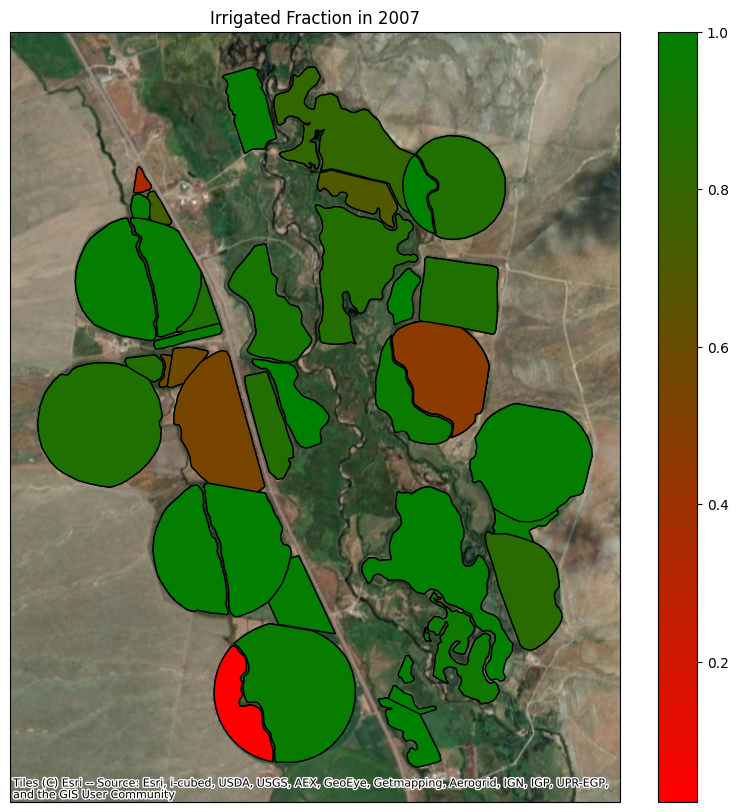

In [9]:
gdf = gpd.read_file(shapefile_path)
gdf.index = gdf['FID_1']

gdf['irr_2007'] = [properties_dict[i]['irr']['2007'] for i in gdf.index]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})

cmap = mcolors.LinearSegmentedColormap.from_list("rg", ["r", "g"])

gdf.plot(ax=ax, 
        edgecolor='black', 
        column='irr_2007',
        cmap=cmap,
        legend=True,
        transform=ccrs.epsg(5071))

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('Irrigated Fraction in 2007')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Looking over historical imagery, it's easy to see that there was not always a center pivot at that location. The difference in the irrigation histories of these fields is very likely due to the installation of a center pivot mid-way through the Landsat record. The pivot continued irrigating the eastern portion of the field, which had likely been flooded or irrigated with a wheel line since before the Landsat era with water from the canal that divides the current field. Only since 2009 has the pivot apparently irrigated the entire pivot area, including the previously dry western portion of the field. This conversion/expansion land use change pattern is common in Montana and the US West generally, and is gratifying to see so obviously in our Landsat-derived information.

This point here emphasizes the utility of good agricultural field boundaries. Only thanks to the diligent efforts of the interns from Montana DNRC's program to develop the Statewide Irrigation Dataset was this field divided in two! While we can still get information from the irrigated and unirrigated portions of the previous single field object, the difference in histories would be somewhat less clear without this precise mapping.

We will take a closer look at the data from these two fields below. 

## 2. Process the Landsat (ETf and NDVI) data and run the agricultural dynamics analysis.

We will run the code to interpolate and join the remote sensing-based data into per-field files first. This interpolates between capture-date NDVI, and marks the capture dates for later use in the calibration step.

We will send the extracted data to Step 2's landsat folder to reduce clutter.

Note: We use `clustered_landsat_time_series` for our data, because we used `clustered_sample_etf` and `clustered_sample_ndvi` when we did the extract. As mentioned when we ran the extraction code in Step 2, there are options for the 'sparse' and 'image'-based extraction; in the module `prep.landsat_sensing`, you will find their analogs for time series processing, i.e., `sparse_landsat_time_series` and `landsat_time_series_image`.

In [9]:
# Step-specific imports
from prep.landsat_sensing import clustered_landsat_time_series, join_remote_sensing, detect_cuttings

In [10]:
# First, we build some tables that interpolate the capture-date data from the extract data we already downloaded:
tutorial_dir = os.path.join(root, 'tutorials', '1_Boulder')
landsat = os.path.join(tutorial_dir,  'data' , 'landsat')
tables = os.path.join(landsat, 'tables')
if not os.path.isdir(tables):
    os.mkdir(tables)
    
extracts = os.path.join(landsat, 'extracts')

types_ = ['inv_irr', 'irr']
sensing_params = ['ndvi', 'etf']

for mask_type in types_:

    for sensing_param in sensing_params:
        
        yrs = [x for x in range(2004, 2024)]

        ee_data, src = None, None

        ee_data = os.path.join(extracts, sensing_param, mask_type)
        src = os.path.join(tables, '{}_{}_{}.csv'.format('tutorial', sensing_param, mask_type))
        src_ct = os.path.join(tables, '{}_{}_{}_ct.csv'.format('tutorial', sensing_param, mask_type))

        clustered_landsat_time_series(shapefile_path, ee_data, yrs, src, src_ct, feature_id='FID_1')


/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/extracts/ndvi/inv_irr


Processing Landsat Time Series: 100%|███████████| 20/20 [00:00<00:00, 31.01it/s]


/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/extracts/etf/inv_irr


Processing Landsat Time Series: 100%|███████████| 20/20 [00:00<00:00, 38.90it/s]


/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/extracts/ndvi/irr


Processing Landsat Time Series: 100%|███████████| 20/20 [00:00<00:00, 30.53it/s]


/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/extracts/etf/irr


Processing Landsat Time Series: 100%|███████████| 20/20 [00:00<00:00, 36.89it/s]


Next, join the daily remote sensing data to a single file, this will be a single, large file to hold all the NDVI and ETf data. 

In [11]:
remote_sensing_file = os.path.join(landsat, 'remote_sensing.csv')
join_remote_sensing(tables, remote_sensing_file)

etf_inv_irr_ct
ndvi_inv_irr_ct
etf_inv_irr
etf_irr
etf_irr_ct
ndvi_inv_irr
ndvi_irr_ct
ndvi_irr


Let's look at the expression of irrigated and unirrigated parcels in terms of NDVI and ETf, using the fields we checked out already. We can single out the fields from the information in the `remote_sensing_file` and plot the NDVI and ETf of the fields. 

In [12]:
# Let's take a look at the data for the fields
df = pd.read_csv(remote_sensing_file, index_col=0)
cols = [c for c in df.columns if '043_000128' in c]
cols += [c for c in df.columns if '043_000130' in c]
df = df[cols]

# Increase the length of the displayed dataframe or change the dates to see more data
df['043_000128_g'] = df['043_000128_ndvi_irr'].diff()
df.loc['2007-06-22': '2007-07-03', [c for c in df.columns if '043_000128' in c]].head(n=35)

,043_000128_ndvi_irr,043_000128_ndvi_irr_ct,043_000128_ndvi_inv_irr,043_000128_etf_irr_ct,043_000128_etf_irr,043_000128_etf_inv_irr,043_000128_ndvi_inv_irr_ct,043_000128_etf_inv_irr_ct,043_000128_g
2007-06-22,0.836939,0,0.486037,0,1.167633,0.812429,0,0,0.000803
2007-06-23,0.837742,1,0.486129,1,1.174462,0.819316,1,1,0.000803
2007-06-24,0.724754,1,0.449568,1,1.096893,0.787087,1,1,-0.112988
2007-06-25,0.708613,0,0.444345,0,1.085812,0.782483,0,0,-0.016141
2007-06-26,0.692471,0,0.439122,0,1.074731,0.777879,0,0,-0.016141
2007-06-27,0.676330,0,0.433899,0,1.063650,0.773275,0,0,-0.016141
2007-06-28,0.660189,0,0.428676,0,1.052569,0.768671,0,0,-0.016141
2007-06-29,0.644048,0,0.423453,0,1.041487,0.764067,0,0,-0.016141
2007-06-30,0.627907,0,0.418230,0,1.030406,0.759463,0,0,-0.016141
2007-07-01,0.611766,1,0.413007,1,1.019325,0.754859,1,1,-0.016141


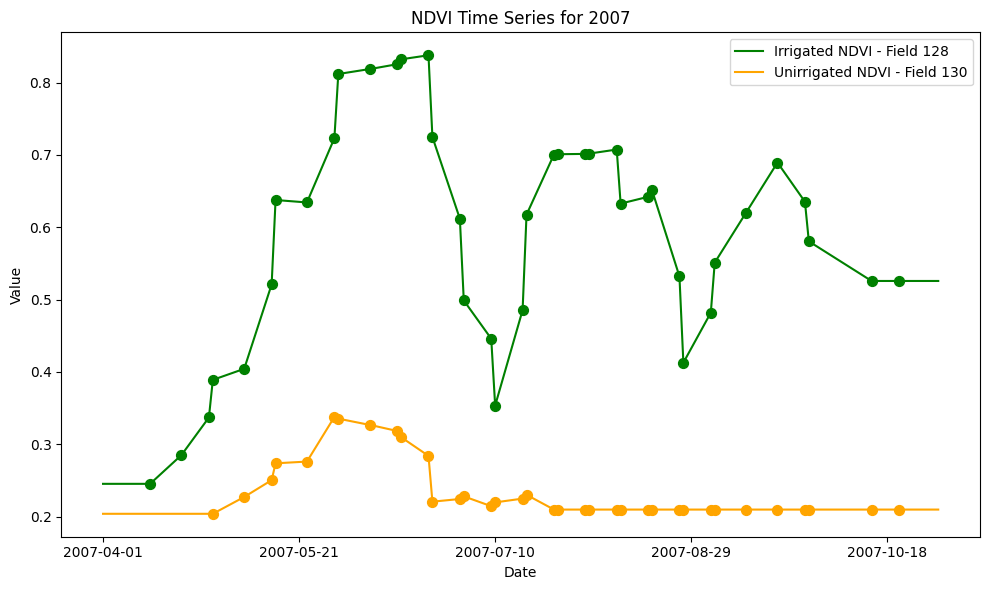

In [13]:
# And plot it, first NDVI
import matplotlib.pyplot as plt
import pandas as pd

# We'll just choose the irrigated portion of 
columns_to_plot = [('043_000128_ndvi_irr', 'Irrigated NDVI - Field 128', 'green'),
                   ('043_000130_ndvi_inv_irr', 'Unirrigated NDVI - Field 130', 'orange')]

fig, ax = plt.subplots(figsize=(10, 6))

df_year = df.loc['2007-04-01': '2007-10-31'].copy()

for column, desc, color in columns_to_plot:
    df_year[column].plot(ax=ax, label=desc, color=color)

    ct_column = column + '_ct'
    scatter_data = df_year[column].copy()
    scatter_data[df_year[ct_column] == 0] = np.nan
    ax.scatter(scatter_data.index, scatter_data, marker='o', s=50, c=color)

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('NDVI Time Series for 2007')
ax.legend()

plt.tight_layout()
plt.show()

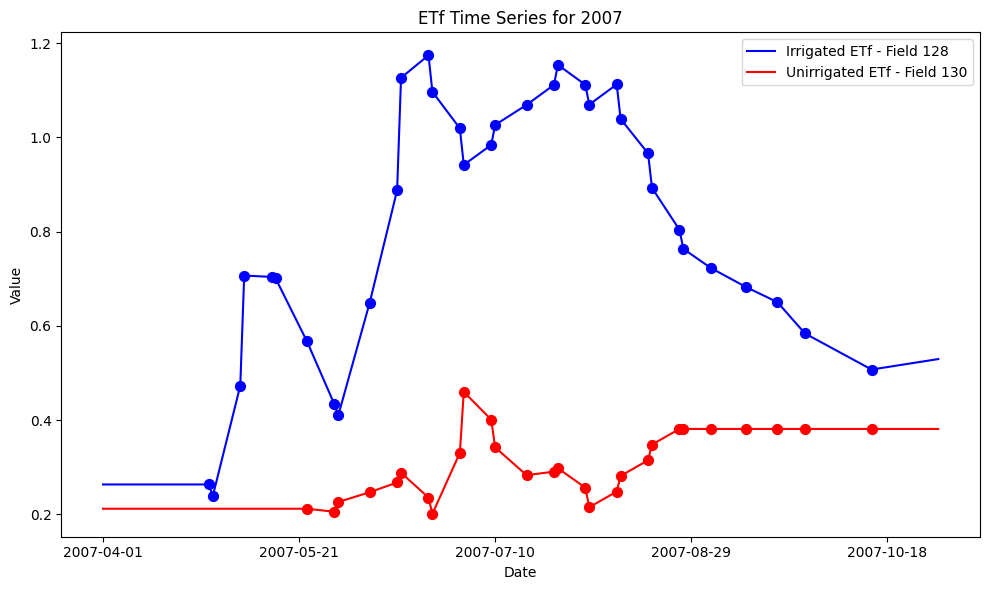

In [14]:
# and ETF

columns_to_plot = [('043_000128_etf_irr', 'Irrigated ETf - Field 128', 'blue'),
                   ('043_000130_etf_inv_irr', 'Unirrigated ETf - Field 130', 'red')]

fig, ax = plt.subplots(figsize=(10, 6))

df_year = df.loc['2007-04-01': '2007-10-31'].copy()

for column, desc, color in columns_to_plot:
    df_year[column].plot(ax=ax, label=desc, color=color)

    ct_column = column + '_ct'
    scatter_data = df_year[column].copy()
    scatter_data[df_year[ct_column] == 0] = np.nan
    ax.scatter(scatter_data.index, scatter_data, marker='o', s=50, c=color)

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('ETf Time Series for 2007')
ax.legend()

plt.tight_layout()
plt.show()

This shows the drastic difference in growing-season remote sensing signals caused by the presence or absence of irrigation. Let's compare the ETf and NDVI signals directly in the irrigated field 128 during 2008, which has some interesting behavior:

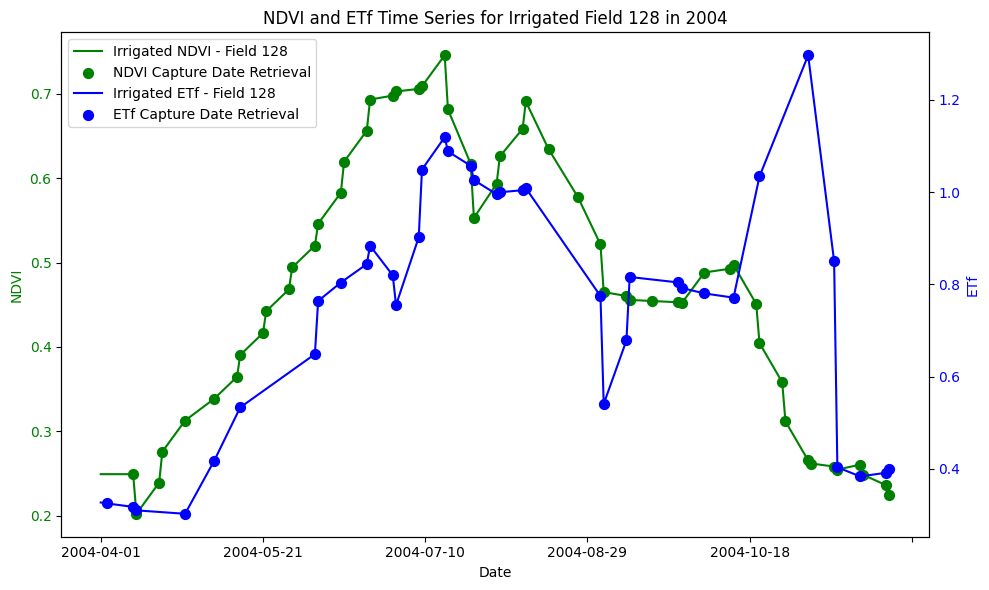

In [15]:
columns_to_plot = [('043_000128_ndvi_irr', 'Irrigated NDVI - Field 128', 'green'),
                   ('043_000128_etf_irr', 'Irrigated ETf - Field 128', 'blue')]

fig, ax1 = plt.subplots(figsize=(10, 6))  # Create the first axes

df_year = df.loc['2004-04-01': '2004-11-31'].copy()

# Plot the NDVI data on the first axes
for column, desc, color in columns_to_plot:
    if 'ndvi' in column:
        df_year[column].plot(ax=ax1, label=desc, color=color)

        ct_column = column + '_ct'
        scatter_data = df_year[column].copy()
        scatter_data[df_year[ct_column] == 0] = np.nan
        ax1.scatter(scatter_data.index, scatter_data, marker='o', s=50, c=color, label='NDVI Capture Date Retrieval')

# Set labels and title for the first axes
ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create the second axes that shares the same x-axis
ax2 = ax1.twinx()

# Plot the ETf data on the second axes
for column, desc, color in columns_to_plot:
    if 'etf' in column:
        df_year[column].plot(ax=ax2, label=desc, color=color)

        ct_column = column + '_ct'
        scatter_data = df_year[column].copy()
        scatter_data[df_year[ct_column] == 0] = np.nan
        ax2.scatter(scatter_data.index, scatter_data, marker='o', s=50, c=color, label='ETf Capture Date Retrieval')

# Set labels for the second axes
ax2.set_ylabel('ETf', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title and legend
plt.title('NDVI and ETf Time Series for Irrigated Field 128 in 2004')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

Notice that while NDVI and ETf are well-correlated at times, they are not the same signal. One of the strengths of SWIM and the soil water balance approach it employs is that they separate the transpirative and evporative components of evapotranspiration. The cool thing in SWIM specifically is that we assume that NDVI (or a factor thereof) can be used as a proxy for the transpirative component (basal crop coefficient; Kcb), and we force the transpirative part of the model with that on a daily basis, so it tracks the state of the vegetation on the ground. The heart of the SWIM approach is allowing NDVI and meteorology alone to drive the model, and leaving our other remote sensing-based tool, ETf, to stand aside from forcing the model and remain *somewhat* independent so it can be used in calibration.

As the ETf signal represents the sum of transpiration *and* evaporation, we can see that it's typical during the growning season for NDVI and ETf to track together, implying that overall ET is dominated by transpiration. On the other hand, we see a very high ETf on about Oct 27 that is not reflected in the NDVI data. This implies that ET on that date is dominated by evaporation. This probably means that the soil is wet and evaporating from a relatively bare surface. It probably rained. SWIM is tracking precipitation and the soil water state, and can therefor exploit these instances during calibration by adjusting the soil parameters such that it can more closely match the infrequent captures of these disparities.

In the next tutorial, we will show that when we calibrate the model using the *capture date* ETf, we can tune the parameters that control the evporative and transpirative components of the model such that they take on the optimal value to enable modeling daily ET with only a sparse NDVI signal.

This is an application of the Dual Crop Coefficient approach, see Allen, 1998; https://edisciplinas.usp.br/pluginfile.php/3887570/mod_folder/content/0/Boletim_FAO56.pdf, and Allen, 2005; https://doi.org/10.1061/(ASCE)0733-9437(2005)131:1(2).

Finally, we use both the irrigation and NDVI data to run an analysis to infer simple agricultural information and get an estimate of the potential irrigation dates. These dates are those where the NDVI signal imply that irrigation may have ocurred. We will see later that there are futher constraints on the model applying irrigation, namely the soil moisture deficit. We choose a low irrigation threshold, below which the irrigation data will not be analyzed and the field will be assumed unirrigated. Let's choose 10% for now.

In [16]:
cuttings_json = os.path.join(landsat, 'tutorial_cuttings.json')
detect_cuttings(remote_sensing_file, irr, irr_threshold=0.1, out_json=cuttings_json)

Analyzing Irrigation: 100%|█████████████████████| 78/78 [00:06<00:00, 12.84it/s]


wrote /home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/tutorial_cuttings.json


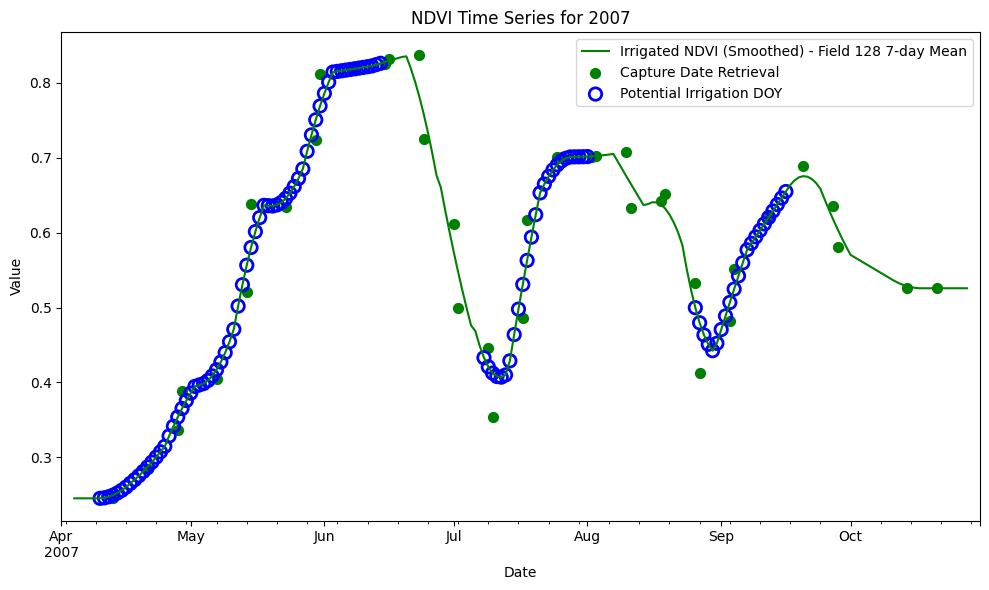

In [18]:
import matplotlib.pyplot as plt

with open(cuttings_json, 'r') as f:
    input_dct = json.load(f)
field = input_dct['043_000128']['2007']

column, desc, color = '043_000128_ndvi_irr', 'Irrigated NDVI (Smoothed) - Field 128', 'green'

fig, ax = plt.subplots(figsize=(10, 6))

df = pd.read_csv(remote_sensing_file, index_col=0)

df_year = df.loc['2007-04-01': '2007-10-31'].copy()
df_year.index = pd.to_datetime(df_year.index)
df_year['doy'] = [i.dayofyear for i in df_year.index]

# Calculate 7-day rolling mean
df_year[column + '_rolling'] = df_year[column].rolling(window=7, center=True).mean()
df_year[column + '_rolling'].plot(ax=ax, label=desc + ' 7-day Mean', color=color)

# df_year[column].plot(ax=ax, label=desc, color=color, alpha=0.5)  # Plot original data with reduced alpha

ct_column = column + '_ct'
scatter_data = df_year[column].copy()
scatter_data[df_year[ct_column] == 0] = np.nan
ax.scatter(scatter_data.index, scatter_data, marker='o', s=50, c=color, label='Capture Date Retrieval')

irr_dates = [pd.to_datetime('2007-01-01') + pd.Timedelta(days=doy - 1) for doy in field['irr_doys']
             if doy in df_year['doy'].tolist()]

ax.scatter(irr_dates, df_year.loc[irr_dates, column + '_rolling'], marker='o', s=80, facecolors='none', edgecolors='blue',
           linewidth=2, label='Potential Irrigation DOY')

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('NDVI Time Series for 2007')
ax.legend()

plt.tight_layout()
plt.show()

Now that we have our files in our `tutorials/1_Boulder/data/landsat` directory (`remote_sesning.csv` and `tutorial_cuttings.json`), we can move on to Step 4b, where we will do the final processing to bring everything together into a model input file.